# 为什么你应该对冲贝塔和行业风险(第二部分)
by Jonathan Larkin and Maxwell Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---


在第一堂关于[为什么你应该对冲贝塔系数和行业风险敞口](quantopian.com/lectures/why-you-should-hedge-beta-and-sector-exposures-part-i)的课上，我们讨论了信息系数(IC)和有效宽度，为尽可能多地进行独立押注提供了更多的理由。在这里，我们通过对不同数量的证券的投资组合进行分解，进一步探讨系统风险的影响，从而扩展本文所详述的概念。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 对冲贝塔和行业风险对分配者有好处(这对你也有好处!)

让我们从两个基本信念出发:
- 你希望有人资助你的算法
- 为你的算法提供资金的机构不会将其100%的资金分配给你。换句话说，你的算法是一系列算法中的一个。

第二种信念的含义很微妙。为什么你的高夏普算法是投资组合的一部分很重要?理解这一点的重要性，以及它与beta和行业敞口之间的关系的关键是以下数学结果:

**在投资组合中，特定股票的风险可以多样化，而共同因素的风险不能。**

<div class="alert alert-warning">
<b>TL;DR:</b> Beta和行业风险敞口是共同因素，即它们是所有股票共有的少数风险特征之一。对共同因素的风险敞口并不会分散到一个algos投资组合中。如果您的算法存在公共因素风险，那么分配器将无法为您进行大量分配。许多算法与适度的共同因素风险相结合，可能导致在投资组合层面上压倒一切的共同因素风险。分配器不喜欢这样。如果你想获得大量资本配置，你必须长期保持较低的贝塔系数和行业风险敞口。
</div>

# 基础

### 个股风险分解

为了建立直觉，我们假设一个单因素模型:

$$r_i = \alpha_i + \beta_i r_m + \epsilon_i$$

其中$\alpha_i$是截距，$\epsilon_i$是误差，$r_m$是市场回报。这是[资本资产定价模型(CAPM)](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory),它假定股票的回报可以归因于其对市场的贝塔加权风险敞口，以及该股票特有的回报。这里有两个重要的假设:$\epsilon_i$与市场无关，也与股票之间无关。有关更多背景知识，请参见[Beta对冲讲座](https://www.quantopian.com/lectures/beta-hedging)。

在这种情况下，用方差衡量的个股的“风险”是:

$$\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\epsilon_i}^2$$

股票方差分为**共同风险**，$\beta_i^2\sigma_m^2$，和**特定风险**，$\sigma_{\epsilon_i}$。**共同风险**是由市场风险驱动的股票风险，在所有股票中是共同的，与股票的贝塔系数成比例。**特定风险**是个别股票特有的风险。

让我们看两个例子，并将风险分解为由共同因素风险引起的百分比。

In [2]:
def stock_risk(beta, market_vol, idio_vol):
    common_risk = (beta**2)*(market_vol**2)
    specific_risk = idio_vol**2
    total_risk = common_risk + specific_risk
    return total_risk, common_risk/total_risk

我们选取了两只不同的股票，每只股票都有不同的市场贝塔系数和特殊波动率。

In [3]:
# Betas
b1 = 1.2
b2 = 1.1
# Market volatility
market_vol = 0.15
# Idiosyncratic volatilities
idio_vol_1 = 0.10 
idio_vol_2 = 0.07

In [4]:
total_1, pct_common_1 = stock_risk(b1, market_vol, idio_vol_1)
total_2, pct_common_2 = stock_risk(b2, market_vol, idio_vol_2)

print ("Stock 1 risk (annualized standard deviation): %0.4f " % np.sqrt(total_1))
print ("Stock 1: percent of total risk due to common risk: %0.4f " % pct_common_1)

print ("\nStock 2 risk (annualized standard deviation): %0.4f " % np.sqrt(total_2))
print ("Stock 2: percent of total risk due to common risk: %0.4f " % pct_common_2)

Stock 1 risk (annualized standard deviation): 0.2059 
Stock 1: percent of total risk due to common risk: 0.7642 

Stock 2 risk (annualized standard deviation): 0.1792 
Stock 2: percent of total risk due to common risk: 0.8475 


这只是看与每个单独的股票相关的风险的分解。我们可以将这些组合成一个投资组合，看看它们的综合波动性如何受到共同因素风险的影响。

### 股票投资组合风险分解

现在，让我们假设您有一个百分比权重为$w_1$和$w_2$的两个股票投资组合。在单因素模型下，投资组合的风险$\Pi$(推导如下)为:

$$\sigma_{\Pi}^2 = \overbrace{\sigma_m^2\left( w_1^2\beta_1^2 + w_2^2\beta_2^2 + 2w_1w_2\beta_1\beta_2 \right)}^{\text{common risk}} + \overbrace{w_1^2\epsilon_1^2 + w_2^2 \epsilon_2^2}^{\text{specifc risk}}$$

这是投资组合因素风险最简单的例子，一个因素和两个资产，但我们已经可以用它来获得投资组合风险和对冲的直觉。

In [5]:
# The weights for each security in our portfolio
w1 = 0.5
w2 = 0.5

In [6]:
def two_stocks_one_factor(w1, w2, b1, b2, market_vol, idio_vol_1, idio_vol_2):
    common_risk = (market_vol**2)*(w1*w1*b1*b1 + w2*w2*b2*b2 + 2*w1*w2*b1*b2)
    specific_risk =  w1*w1*idio_vol_1**2 + w2*w2*idio_vol_2**2
    total_risk = common_risk + specific_risk
    return total_risk, common_risk/total_risk

两支股票、同等权重、只做多的投资组合的风险:

In [7]:
total, pct_common = two_stocks_one_factor(w1, w2, b1, b2, market_vol, idio_vol_1, idio_vol_2)
print("Portfolio risk (annualized standard deviation): %0.4f " % np.sqrt(total))
print ("Percent of total risk due to common risk: %0.4f" % pct_common)

Portfolio risk (annualized standard deviation): 0.1830 
Percent of total risk due to common risk: 0.8887


敏锐的读者会注意到，在投资组合中，由共同因素风险引起的风险所占的比例，在投资组合中**大于两部分共同风险比例的加权和**。重复一下这节课的重点:**在投资组合中，特定股票的风险分散，而共同因素的风险不分散**

两支股票、贝塔对冲多空组合的风险:

In [8]:
w2 = -w1*b1/b2    # set weight 2 such that the portfolio has zero beta

total, pct_common = two_stocks_one_factor(w1, w2, b1, b2, market_vol, idio_vol_1, idio_vol_2)
print ("Portfolio risk (annualized standard deviation): %0.4f " % np.sqrt(total))
print ("Percent of total risk due to common risk: %0.4f" % pct_common)

Portfolio risk (annualized standard deviation): 0.0629 
Percent of total risk due to common risk: 0.0000


注意，我们用完美的贝塔对冲消除了**所有**共同风险。

# 投资组合风险

如果$X$是n个随机变量的列向量，$X_1，\dots,X_n$， $c$是系数(常数)的列向量，那么[加权和的方差](https://en.wikipedia.org/wiki/Variance) $c'X$是

$$\text{Var}(c'X) = c'\Sigma c$$

其中$\Sigma$是$X$的协方差矩阵。

在我们的应用中，$c$是我们的股票权重向量$w$， $\Sigma$是股票收益的协方差矩阵。

$$\sigma_{\Pi}^2 = w' \Sigma w$$

就像我们分解上面的单个股票风险一样，我们可以将协方差矩阵分解为单独的*共同风险*和*特定风险*

$$\Sigma = BFB' + D$$

因此

$$\sigma_{\Pi}^2  = w'(BFB' + D)w$$
$$\sigma_{\Pi}^2  = w'BFB'w + w'Dw$$

上述两种股票投资组合的计算结果是

\begin{equation}
\sigma_{\Pi}^2 =
\overbrace{
\begin{bmatrix} w_1 & w_2 \end{bmatrix}
\begin{bmatrix} \beta_{1} \\ \beta_{2} \end{bmatrix} 
\sigma_m^2
\begin{bmatrix} \beta_{1} & \beta_{2} \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}
}^{\text{common risk}}
+ \overbrace{\begin{bmatrix} w_1 & w_2 \end{bmatrix}
\begin{bmatrix} \epsilon_1^2 & 0\\ 0 & \epsilon_2^2 \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}}^{\text{specific risk}}
\end{equation}

如果你做一下这个矩阵乘法，你就会得到上面所说的结果

$$\sigma_{\Pi}^2 = \overbrace{\sigma_m^2\left( w_1^2\beta_1^2 + w_2^2\beta_2^2 + 2w_1w_2\beta_1\beta_1 \right)}^{\text{common risk}} + \overbrace{w_1^2\epsilon_1^2 + w_2^2 \epsilon_2^2}^{\text{specifc risk}}$$

### 多因素模型

当然，我们可以扩展CAPM以包括市场beta以外的*额外*风险因素。我们可以假设，所有股票共有的$m$种风险。

$$r_i = \alpha_i + \beta_{1,i} f_1 + \dots + \beta_{m,i} f_m + \epsilon_i$$

或者更简洁

$$r_i = \alpha_i + \sum_{j=1}^m \beta_{j,i} f_j + \epsilon_i$$

或者，考虑所有的股票，$i$,从1到N，更精确地说，在给定的时间段内，

$$r = \alpha + Bf + \epsilon$$

其中$r$是收益的Nx1列向量，$B$是因子贝塔的Nx$m$矩阵，$f$是因子收益的mx1列，$\epsilon$是特质收益的Nx1列向量。最后,

$$\sigma_{\Pi}^2  = w'BFB'w + w'Dw$$

其中$B$是因子贝塔的Nx$m$矩阵，$F$是因子回报的$m$x$m$协方差矩阵，$D$是一个NxN矩阵，它在对角线上为$\epsilon_i$的方差，其他地方都是0。

有了这个结果，*假设我们有一个合适的风险模型给定我们矩阵$B$， $F$和$D$*，我们可以计算我们的投资组合风险和来自共同风险的风险比例。

同样，正如我们在上述两种股票情况中设置$w_2$为抵消单一因素$\beta$的风险敞口的值一样，在多因素情况下，我们可以使用因素betas矩阵$B$来构建一个对**所有**公共因子都是中性的投资组合。**对所有公共因子均为中性的投资组合，其公共因子风险为零**


# 投资组合的算法

即使没有风险模型，我们也可以对一组算法的风险有一些直观的认识。

当个体的风险不为零时，所产生的组合是什么样子的呢?加维、卡恩和萨维最近在期刊上发表的一篇文章[多样化的危险](http://www.iijournals.com/doi/abs/10.3905/jpm.2017.43.2.013?journalCode=jpm)给了我一些启发，让我想象一下，每一个算法都有一定的“共同风险预算”。该预算被定义为算法中总风险的共同风险百分比。

在第一种情况下，我们假设所有的算法都有相同的预算(并且使用所有的预算!)，它们的共同风险之间的相关性为1.0。这与单因素模型的情况类似。



In [16]:
def portfolio_risk_decomposition(budget, correl, algo_count, algo_total_risk=0.04):
    N = algo_count
    
    algo_common_risk = budget*(algo_total_risk**2)
    algo_idio_risk = algo_total_risk**2 - algo_common_risk

    w = 1./N
    
    covar = correl*algo_common_risk
    common_risk = N*w*w*algo_common_risk + (N*N - N)*w*w*covar
    idio_risk = algo_idio_risk*w
    total_risk = common_risk + idio_risk
    
    return total_risk, common_risk/total_risk

In [17]:
a, b = portfolio_risk_decomposition(budget=0.2, algo_count=20, correl=1.0, algo_total_risk=0.04)
print ("Portfolio total risk: %.4f " % np.sqrt(a))
print ("Portfolio percent of common risk: %.4f " % b)

Portfolio total risk: 0.0196 
Portfolio percent of common risk: 0.8333 


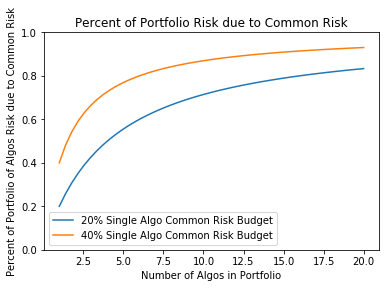

In [18]:
algos = np.linspace(1,20)
plt.plot(
    algos,
    portfolio_risk_decomposition(budget=0.2, correl=1.0, algo_count=algos)[1]
)
plt.plot(
    algos,
    portfolio_risk_decomposition(budget=0.4, correl=1.0, algo_count=algos)[1]
)
plt.ylim([0,1]);
plt.title('Percent of Portfolio Risk due to Common Risk')
plt.xlabel('Number of Algos in Portfolio')
plt.ylabel('Percent of Portfolio of Algos Risk due to Common Risk')
plt.legend(
    ['20% Single Algo Common Risk Budget', '40% Single Algo Common Risk Budget']
);

从这个图中，您可以看到，从分配者的角度来看，一个允许单个算法总风险的20%由共同风险驱动的“小”预算导致了一个20个算法投资组合，其中**83%**的风险由共同风险驱动!理想情况下，分配者希望您的**共同因素风险为零**。

<div class="alert alert-warning">
<b>TL;DR:</b>即使你不能预测投资组合的风险，也没有一个风险模型来分解风险，你也可以通过对冲公共因子的风险来形成一个**公共风险为零**的投资组合。美国股市最重要的共同因素是市场贝塔系数和行业贝塔系数。对冲你的贝塔和中立的部门，如果你想要一个大的分配从任何分配者。
</div>